In [1]:
from urllib.request import urlretrieve
import os
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline  

URM_file = open(r"C:\Users\aless\PYTHON_NOTEBOOKS\RECOMMENDER_CHALLENGE\data_train.csv", 'r')

def rowSplit (rowString):
    
    split = rowString.split(",")
    split[2] = split[2].replace("\n","")
    
    split[0] = int(split[0])#userID = row o forse row+1?? Dipende da come pensiamo id
    split[1] = int(split[1])#itemId =column
    split[2] = int(float(split[2]))#rating IMPLICIT
    result = tuple(split)
    
    return result



URM_file.seek(0)
URM_tuples = []
URM_file.readline()#questa è importante di cristo c'è riga di introduzione
for line in URM_file:
    URM_tuples.append(rowSplit (line))


#ora devo costruire saggiamente la matrice


data = np.array(URM_tuples)
#print("Numero di rating:"+str(data.shape[0]))
#crea URM
result = np.zeros((data[:,0].max()+1, data[:,1].max()+1), dtype=int)
result[data[:,0], data[:,1]] = data[:,2] 

userList=set(data[:,0])#significa tutte le righe considerando solo la colonna 1
itemList=set(data[:,1])
ratingList=data.shape[0]

print("Num Utenti: "+str(len(userList)))
print("Num Items: "+str(len(itemList)))
print("Num Ratings: "+str(ratingList)) #sarà righe-1 di itnestazione
print(result.shape)#forma della matrice 


import scipy.sparse as sps

URM_all = sps.coo_matrix(result)
URM_all = URM_all.tocsr()

Num Utenti: 7947
Num Items: 24896
Num Ratings: 113268
(7947, 25975)


In [4]:
from Notebooks_utils.data_splitter import train_test_holdout
from Notebooks_utils.evaluation_function import evaluate_algorithm
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python


URM_train, URM_test = train_test_holdout(URM_all, train_perc = 0.8)#sono traine test locali,aka train e valiation
#-----------------------------------------------------------------------
#-------------------------STUFF-----------------------------------------
#-----------------------------------------------------------------------
from Base.Evaluation.Evaluator import EvaluatorHoldout
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])#perchè ne voglio solo 10 suppongo

class UserKNNCFRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        
        scores = self.W_sparse[user_id, :].dot(self.URM).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

## Prameter tuning


UserKNNCFRecommender: URM Detected 73 (0.92 %) cold users.
UserKNNCFRecommender: URM Detected 2374 (9.14 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 3460.34 column/sec, elapsed time 0.04 min
EvaluatorHoldout: Processed 5640 ( 100.00% ) in 3.08 sec. Users per second: 1833
Numero di Neighbours= 10 MAP= 0.039452734674444996

UserKNNCFRecommender: URM Detected 73 (0.92 %) cold users.
UserKNNCFRecommender: URM Detected 2374 (9.14 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 3392.18 column/sec, elapsed time 0.04 min
EvaluatorHoldout: Processed 5640 ( 100.00% ) in 3.30 sec. Users per second: 1710
Numero di Neighbours= 50 MAP= 0.053610165702411686

UserKNNCFRecommender: URM Detected 73 (0.92 %) cold users.
UserKNNCFRecommender: URM Detected 2374 (9.14 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 31

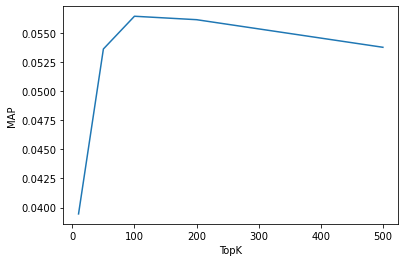

In [8]:
from KNN.UserKNNCFRecommender import UserKNNCFRecommender

x_tick = [10, 50, 100, 200, 500]#100 è il top
#x_tick = [100]#100 è il top
MAP_per_k = []

for topK in x_tick:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_dict[10]["MAP"])
    print("Numero di Neighbours= "+str(topK)+" MAP= "+str(result_dict[10]["MAP"])+"\n")
    
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

In [ ]:
x_tick = [0,1,2,3,4,5,6,10]#1 e 3 top
#x_tick = [3]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)
    
    result_dict, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_dict[10]["MAP"])
    print("Shrink term= "+str(shrink)+" MAP= "+str(result_dict[10]["MAP"])+"\n")
    
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

UserKNNCFRecommender: URM Detected 73 (0.92 %) cold users.
UserKNNCFRecommender: URM Detected 2374 (9.14 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 3270.32 column/sec, elapsed time 0.04 min
EvaluatorHoldout: Processed 5640 ( 100.00% ) in 3.41 sec. Users per second: 1653
Shrink term= 0 MAP= 0.05642181527851481

UserKNNCFRecommender: URM Detected 73 (0.92 %) cold users.
UserKNNCFRecommender: URM Detected 2374 (9.14 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 3154.26 column/sec, elapsed time 0.04 min
EvaluatorHoldout: Processed 5640 ( 100.00% ) in 3.66 sec. Users per second: 1539
Shrink term= 1 MAP= 0.05628519161801839

UserKNNCFRecommender: URM Detected 73 (0.92 %) cold users.
UserKNNCFRecommender: URM Detected 2374 (9.14 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 3087.01 column/sec, elap